<a href="https://colab.research.google.com/github/DinethRashmikaHeshan/DL_Lab04/blob/main/autonomous_driving_application_car_detection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Lab 4 – Autonomous Driving: Car Detection with CNNs**

In this lab, you will explore **object detection** using the powerful **YOLO (You Only Look Once)** model, a state-of-the-art Convolutional Neural Network (CNN) for real-time detection tasks.  

By working through this exercise, you will:  
- Understand how to **represent and work with bounding boxes** in images.  
- Apply YOLO to detect **cars and other road objects** in realistic driving scenarios.  
- Experiment with **confidence thresholds, class filtering, and detection statistics** to see how model parameters affect results.  
- Visualize **CNN feature maps (activation heatmaps)** to gain intuition about how detectors “see” objects.  
- Analyze results to discuss **false positives, false negatives, and model sensitivity**.  

This lab builds directly on your **CNN lecture**, connecting core theory (convolutions, pooling, feature extraction) to a **real-world computer vision application**: **autonomous driving and traffic scene analysis**.



## Mount the Google Drive

In [32]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# Extract the Zip Folder

Change the path according to your file location

In [33]:
!unzip "/content/drive/MyDrive/Lab 4.zip" -d "content/"

Archive:  /content/drive/MyDrive/Lab 4.zip
replace content/Lab 4/font/FiraMono-Medium.otf? [y]es, [n]o, [A]ll, [N]one, [r]ename: 

# Import Packages and Setup

### Setup and Dependencies

In this step, we install and import the key libraries required for the lab:

- **Ultralytics** - Provides the YOLOv8 object detection framework.  
- **OpenCV (cv2)** - Useful for image processing and computer vision utilities.  
- **Pillow (PIL)** - For handling and drawing on images.  
- **Matplotlib** - For plotting and visualizations.  
- **TensorFlow** - For exploring CNN concepts and verifying environment setup.

We also check the TensorFlow version and whether **Eager Execution** is enabled, ensuring compatibility with modern deep learning workflows.


In [34]:
!pip -q install --upgrade ultralytics opencv-python pillow matplotlib

import os, glob
import numpy as np
from typing import Tuple
from PIL import Image, ImageDraw
import tensorflow as tf
import matplotlib.pyplot as plt

print("TensorFlow:", tf.__version__)
print("Eager execution:", tf.executing_eagerly())

TensorFlow: 2.19.0
Eager execution: True


In [35]:
import sys

sys.path.insert(0, "/content/content/Lab 4")
import yolo_utils

### Loading and Running YOLOv8

In this section, we load a lightweight **pretrained YOLOv8 model** (`yolov8n.pt`) provided by Ultralytics.  
This model is trained on the COCO dataset and is suitable for fast inference on common objects, including cars.  

The helper function `run_yolov8` is defined to:  
- Run YOLO inference on a given image.  
- Apply a **confidence threshold** (default 0.25) to filter low-confidence detections.  
- Apply an **IoU threshold** (default 0.45) to control Non-Maximum Suppression (removing overlapping boxes).  
- Return three arrays:  
  - Bounding boxes in `(y1, x1, y2, x2)` format.  
  - Confidence scores for each detection.  
  - Predicted class IDs.  

This function standardizes outputs, making them easy to use for further analysis and visualization later in the lab.


In [36]:
from ultralytics import YOLO

# Load a small pretrained pytorch model
model = YOLO("yolov8n.pt")
print("Loaded YOLOv8 model")

def run_yolov8(image_path, score_threshold=0.6, iou_threshold=0.45):
    results = model.predict(image_path, conf=score_threshold, iou=iou_threshold, verbose=False)
    if not results or results[0].boxes is None:
        return np.zeros((0,4), np.float32), np.zeros((0,), np.float32), np.zeros((0,), np.int32)
    r = results[0]
    xyxy = r.boxes.xyxy.cpu().numpy().astype(np.float32)  # (x1,y1,x2,y2)
    conf = r.boxes.conf.cpu().numpy().astype(np.float32)
    cls  = r.boxes.cls.cpu().numpy().astype(np.int32)
    yx = xyxy[:, [1,0,3,2]]  # → (y1,x1,y2,x2)
    return yx, conf, cls

Loaded YOLOv8 model


### Drawing Detection Boxes on Images

The function `draw_boxes` is used to visualize YOLO detections directly on images.  
It takes as input the image path, bounding boxes, confidence scores, and class labels, and then overlays them on the image.  

Key features of this function:  
- **Bounding box drawing**: Green rectangles are drawn around detected objects.  
- **Labels**: Each box is annotated with the class name (or ID) and its confidence score.  
- **Filtering options**:  
  - `min_score` filters out low-confidence predictions.  
  - `wanted_idx` allows drawing only a specific class (e.g., cars only).  
- **Font handling**: Attempts to use a TrueType font if available, otherwise defaults to system font.  
- **Saving results**: If `save_back=True`, the function saves the annotated image back to disk with a suffix (e.g., `_detected`).  

The function returns:  
1. The annotated `PIL.Image` object.  
2. The number of drawn detections.  
3. The file path of the saved image (if saving is enabled).  

This step provides a convenient way to **inspect detection quality visually** and generate results for reports.


In [37]:
from PIL import ImageDraw, ImageFont

from PIL import ImageDraw, ImageFont

def draw_boxes(image_path, boxes, scores, classes,
               class_names=None, wanted_idx=None,
               min_score=0.25, font_path="font/arial.ttf",
               save_back=False, suffix="_detected"):
    """
    Draw boxes on image, optionally overwrite/save back into images folder.
    """
    img = Image.open(image_path).convert("RGB")
    draw = ImageDraw.Draw(img)
    try:
        font = ImageFont.truetype(font_path, 14)
    except:
        font = None

    count = 0
    for b, s, c in zip(boxes, scores, classes):
        if s < min_score:
            continue
        if wanted_idx is not None and c != wanted_idx:
            continue
        y1, x1, y2, x2 = [int(v) for v in b]
        draw.rectangle([x1, y1, x2, y2], outline=(0,255,0), width=3)
        label = f"{class_names[c] if class_names else c}: {s:.2f}"
        draw.text((x1+3, max(0, y1-12)), label, fill=(255,255,0), font=font)
        count += 1

    # save back into same folder
    if save_back:
        base, ext = os.path.splitext(image_path)
        new_path = f"{base}{suffix}{ext}"   # e.g. 0114_detected.jpg
        img.save(new_path)
        print(f"Saved annotated image: {new_path}")
        return img, count, new_path

    return img, count


### Post-Processing with TensorFlow

The helper function `postprocess_with_tf2` refines the raw YOLOv8 detections using TensorFlow utilities for bounding box handling.  
It allows consistent filtering, class selection, and non-maximum suppression (NMS) in a **TensorFlow-friendly pipeline**.

Steps inside the function:
1. **Run YOLOv8**: Calls `run_yolov8` to get raw detections (boxes, confidence, class IDs).  
2. **Tensor Conversion**: Converts confidence scores and bounding boxes to TensorFlow tensors.  
3. **One-Hot Encoding of Classes**: Builds a one-hot representation of predicted classes for TensorFlow operations.  
4. **Bounding Box Post-Processing**: Uses `yolo_eval` to apply:  
   - Confidence threshold filtering.  
   - IoU threshold filtering (Non-Maximum Suppression).  
   - Per-class NMS to handle overlapping boxes of the same object.  
5. **Class Filtering**: If a `wanted_class` is specified (e.g., `"car"`), detections are restricted to that class only.  
6. **Returns**:  
   - Final confidence scores.  
   - Refined bounding boxes in `(y1, x1, y2, x2)` format.  
   - Predicted class IDs.

This post-processing step is useful for comparing **YOLO’s built-in handling** with a **TensorFlow-based approach**, and for seamlessly integrating detections into downstream TensorFlow models or pipelines.


In [38]:
def postprocess_with_tf2(image_path, score_threshold=0.25, iou_threshold=0.5, max_boxes=50, wanted_class="car"):
    # Get YOLOv8 raw detections
    yx_boxes, conf, cls = run_yolov8(image_path, score_threshold=0.0, iou_threshold=0.7)
    if yx_boxes.shape[0] == 0:
        return np.zeros((0,), np.float32), np.zeros((0,4), np.float32), np.zeros((0,), np.int32)

    N, C = yx_boxes.shape[0], len(class_names)
    box_conf = tf.convert_to_tensor(conf.reshape(1, N, 1), dtype=tf.float32)
    boxes    = tf.convert_to_tensor(yx_boxes.reshape(1, N, 4), dtype=tf.float32)

    # One-hot class probabilities
    probs = np.zeros((1, N, C), dtype=np.float32)
    for i, c in enumerate(cls):
        if 0 <= c < C:
            probs[0, i, c] = 1.0
    box_probs = tf.convert_to_tensor(probs, dtype=tf.float32)

    with Image.open(image_path) as im:
        H, W = im.height, im.width

    scores, fboxes, classes = yolo_eval(
        box_conf, boxes, box_probs,
        image_shape=(H, W),
        max_boxes=max_boxes,
        score_threshold=score_threshold,
        iou_threshold=iou_threshold,
        per_class_nms=True
    )

    # Optionally filter wanted class
    if wanted_class in class_names:
        idx = class_names.index(wanted_class)
        mask = tf.where(classes == idx)[:,0]
        scores = tf.gather(scores, mask)
        fboxes = tf.gather(fboxes, mask)
        classes = tf.gather(classes, mask)

    return scores.numpy(), fboxes.numpy(), classes.numpy()


## Test YOLO Pretrained Model on Images



In this step, we prepare the **label space** and **anchor priors** used by YOLO:
- **COCO class names** (`coco_classes.txt`): human-readable labels for each predicted class.
- **YOLO anchors** (`yolo_anchors.txt`): width–height priors (in pixels) that guide the detector when proposing bounding boxes.

The code below:
1. Loads class names and anchor boxes from your `model_data/` folder.  
2. Computes basic stats (number of classes/anchors).  
3. Prints a quick preview of both to verify the setup.

> If your files are in a different location, update `class_file` and `anchors_path` accordingly.

### **What Are Anchors in YOLO?**

**Anchors** are predefined bounding box shapes (width × height) that act as *priors* to help YOLO detect objects of different sizes and aspect ratios.  
Instead of predicting bounding boxes from scratch, YOLO learns **offsets** relative to these anchors.

- Each grid cell on the feature map predicts multiple bounding boxes, one per anchor.  
- Anchors are chosen to reflect common object shapes in the training dataset (e.g., tall boxes for people, wide boxes for cars).  
- During training, YOLO matches ground truth boxes to the **closest anchor shape**, making learning more stable.  

**Why are anchors useful?**
- They let the model efficiently handle **multi-scale objects** in the same image.  
- They reduce the search space for bounding box regression, speeding up detection.  
- They improve accuracy by giving the network better "starting guesses" for box shapes.

In practice, YOLO uses 9 anchor boxes (in YOLOv3/v4) or different sets depending on the variant, tuned for the COCO dataset.  
Your `yolo_anchors.txt` file defines these anchor dimensions, which are loaded above and used during inference.



In [39]:
# Load class names from model_data
class_file = "/content/content/Lab 4/model_data/coco_classes.txt"   # adjust path if needed
anchors_path = "/content/content/Lab 4/model_data/yolo_anchors.txt"
class_names = yolo_utils.read_classes(class_file)
anchors = yolo_utils.read_anchors(anchors_path)

num_classes = len(class_names)
num_anchors = anchors.shape[0]

print("Loaded", len(class_names), "classes.")
print("Example:", class_names[:50])
print("Loaded", len(anchors), "anchors.")
print("Example:", anchors[:10])

Loaded 80 classes.
Example: ['person', 'bicycle', 'car', 'motorbike', 'aeroplane', 'bus', 'train', 'truck', 'boat', 'traffic light', 'fire hydrant', 'stop sign', 'parking meter', 'bench', 'bird', 'cat', 'dog', 'horse', 'sheep', 'cow', 'elephant', 'bear', 'zebra', 'giraffe', 'backpack', 'umbrella', 'handbag', 'tie', 'suitcase', 'frisbee', 'skis', 'snowboard', 'sports ball', 'kite', 'baseball bat', 'baseball glove', 'skateboard', 'surfboard', 'tennis racket', 'bottle', 'wine glass', 'cup', 'fork', 'knife', 'spoon', 'bowl', 'banana', 'apple', 'sandwich', 'orange']
Loaded 5 anchors.
Example: [[    0.57273     0.67739]
 [     1.8745      2.0625]
 [     3.3384      5.4743]
 [     7.8828      3.5278]
 [     9.7705      9.1683]]


### Testing YOLOv8 on a Sample Road Scene

In this step, we run **YOLOv8** directly on a chosen test image (e.g., a road scene).  

Process:
1. **Select an image** – here `0114.jpg` is used from the dataset.  
2. **Run YOLOv8 inference** using `run_yolov8` with a confidence threshold of `0.25` and IoU threshold of `0.45`.  
3. **Filter detections** so that only the target class (`car`) is drawn.  
4. **Visualize results** with `draw_boxes`, which overlays bounding boxes and labels onto the image.  
5. **Output** the number of detected cars and the annotated image.  

This confirms the model can correctly identify cars in a realistic driving scenario and gives a first look at the quality of detections.


Cars detected (direct): 15


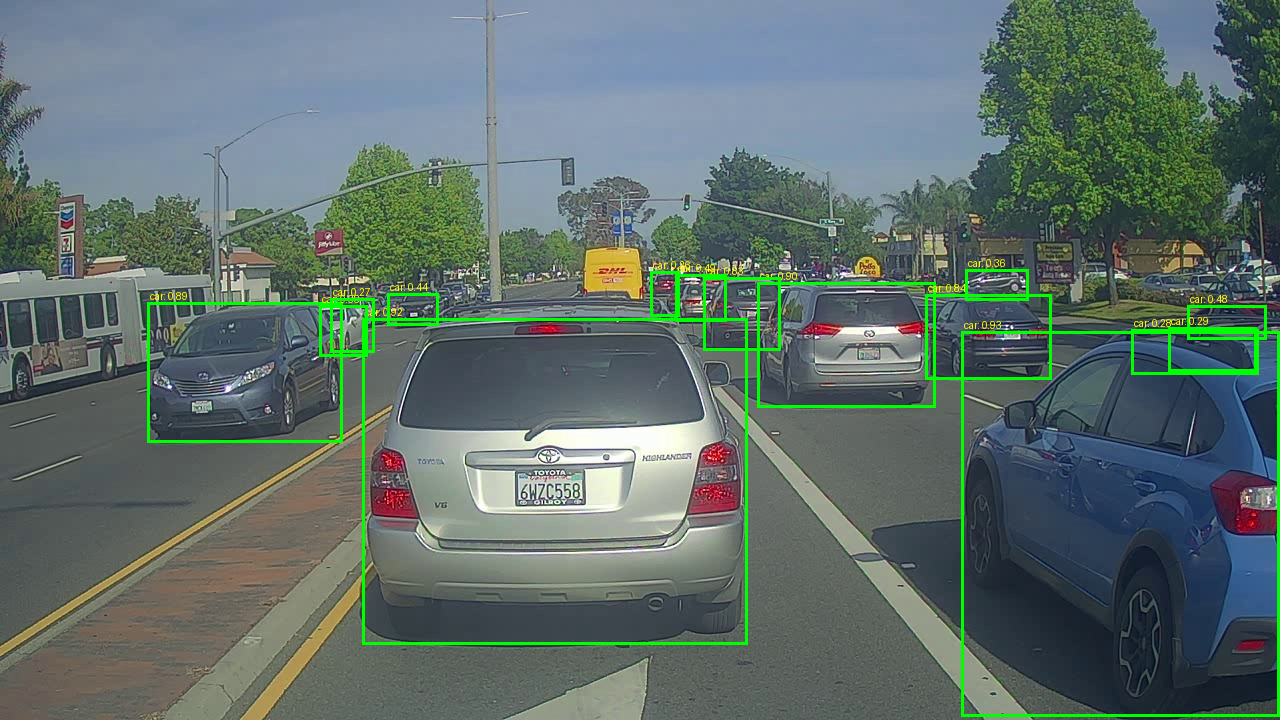

In [61]:
image_path = "/content/content/Lab 4/images/test.jpg"   # put your test road scene here

# Direct YOLOv8
boxes, scores, classes = run_yolov8(image_path, score_threshold=0.1, iou_threshold=0.75)
vis, count = draw_boxes(image_path, boxes, scores, classes, class_names=class_names, wanted_idx=class_names.index("car"))
print("Cars detected (direct):", count)
display(vis)



### Confidence & IoU Thresholds — What They Mean and What to Try

When you call `run_yolov8(image_path, score_threshold=0.25, iou_threshold=0.45)`, two key thresholds control what boxes you see:

1) Confidence (score) threshold  
- Meaning: Minimum predicted confidence for a box to be kept (objectness × class score).  
- Lower value (e.g., 0.25): keeps more boxes → more true positives but also more false positives.  
- Higher value (e.g., 0.60 or 0.90): keeps fewer boxes → fewer false positives but risks missing true objects.

2) IoU threshold (used in Non-Maximum Suppression, NMS)  
- Meaning: Intersection-over-Union overlap at which two boxes are considered “the same” object and the lower-scored one is suppressed.  
- Lower IoU (e.g., 0.45): more aggressive suppression → fewer overlapping boxes, may drop some valid close boxes.  
- Higher IoU (e.g., 0.75): less aggressive suppression → can keep more overlapping boxes, may show duplicates on the same object.

Exercise:
- Run the cell above code as it is, then change `score_threshold` to 0.30, 0.60, 0.90 and observe: number of cars, missed detections, and spurious boxes.  
- Try `iou_threshold` values 0.45 vs 0.75 and note how overlapping boxes behave.  
- Record your observations (2–3 sentences) about the precision–recall trade-off.


### Batch Processing a Folder of Images

So far, we have tested YOLO on a **single image**.  
The helper function `process_folder` extends this by running inference on **all images in a folder** and automatically producing a simple report.

What the function does:
1. Loops through each file in the specified `folder` (default = `"images"`).  
2. Runs `run_yolov8` to detect objects.  
3. Calls `draw_boxes` to visualize **only cars** (`wanted_idx=car`).  
4. Saves annotated images into an output folder (`out/`) if `save_out=True`.  
5. Builds a report listing the image filename and the number of cars detected (or an error message if inference failed).  

**Return Value:**  
A Python list of `(filename, car_count)` pairs, e.g.:
```python
[("0114.jpg", 3), ("0115.jpg", 5), ("0116.jpg", 0)]


In [40]:
def process_folder(folder="images", min_score=0.25, save_out=True):
    out_dir = "out"
    os.makedirs(out_dir, exist_ok=True)
    report = []
    for img_file in glob.glob(os.path.join(folder, "*.*")):
        try:
            boxes, scores, classes = run_yolov8(img_file, score_threshold=min_score, iou_threshold=0.45)
            vis, car_count = draw_boxes(img_file, boxes, scores, classes, class_names=class_names, wanted_idx=class_names.index("car"))
            if save_out:
                vis.save(os.path.join(out_dir, os.path.basename(img_file)))
            report.append((os.path.basename(img_file), car_count))
        except Exception as e:
            report.append((os.path.basename(img_file), f"error: {e}"))
    return report

# Example:
# counts = process_folder("images")
# counts


In [41]:
#Example:
counts = process_folder("/content/content/Lab 4/images")
counts

[('0109.jpg', 6),
 ('test.jpg', 13),
 ('0105.jpg', 3),
 ('0112.jpg', 2),
 ('0101.jpg', 1),
 ('0107.jpg', 2),
 ('0110.jpg', 5),
 ('0113.jpg', 2),
 ('0120.jpg', 5),
 ('0102.jpg', 2),
 ('0104.jpg', 1),
 ('0106.jpg', 4),
 ('0100.jpg', 1),
 ('0108.jpg', 3),
 ('0116.jpg', 1),
 ('giraffe_resized.jpg', 0),
 ('0103.jpg', 2),
 ('0119.jpg', 5),
 ('0115.jpg', 1),
 ('0111.jpg', 2),
 ('0117.jpg', 3),
 ('0118.jpg', 2),
 ('DSC_1643_resized.jpg', 6),
 ('0114.jpg', 1)]

### Advanced Task 1: Class-wise Filtering and Comparison

So far you filtered only one class (e.g., `car`).  
**Now extend this idea** to detect and compare **two classes** (e.g., `car` vs `person`).  

- Run detection for both classes separately.  
- Count how many detections appear for each class across your dataset.  
- Plot a **bar chart** comparing the counts.  

**Deliverable:** A bar chart with class counts and a short note (2–3 sentences) on which class the model detects more reliably in your dataset.


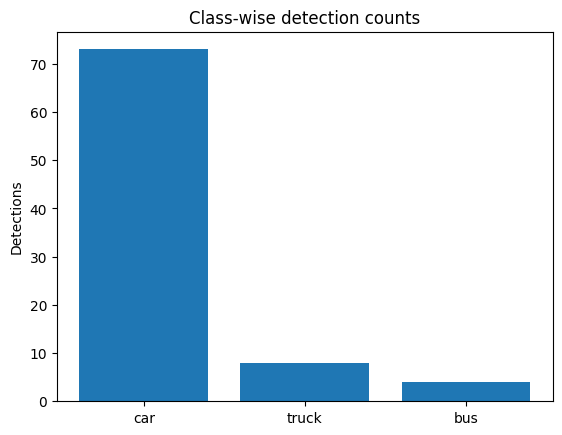

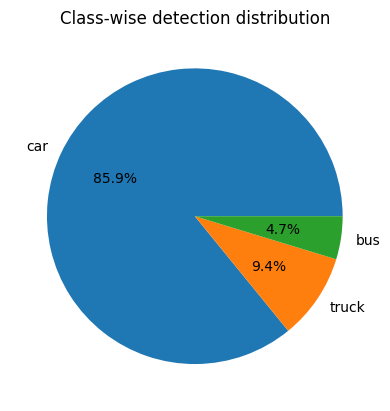

In [42]:
from collections import Counter
# Multi-class comparison
target_classes = ["car", "person", "bus", "truck", "motorcycle"]
name_to_id = {v:k for k,v in model.names.items()}

counts = Counter()

for img_file in glob.glob("/content/content/Lab 4/images/*.*"):
    results = model.predict(img_file, conf=0.25, iou=0.45, verbose=False)
    r = results[0]
    if r.boxes is None:
        continue
    cls_ids = r.boxes.cls.cpu().numpy().astype(int)
    for t in target_classes:
        if name_to_id[t] in cls_ids:
            counts[t] += (cls_ids == name_to_id[t]).sum()

# Bar chart
plt.bar(counts.keys(), counts.values())
plt.ylabel("Detections")
plt.title("Class-wise detection counts")
plt.show()

# Pie chart version
plt.pie(counts.values(), labels=counts.keys(), autopct="%1.1f%%")
plt.title("Class-wise detection distribution")
plt.show()

### Advanced Task 2: Threshold Sweep with Detection Counts

You already tried changing confidence manually.  
Now automate it:
- Sweep across confidence thresholds (0.1 → 0.9).  
- Count how many cars are detected at each threshold.  
- Plot detections vs threshold as a line chart.

**Deliverable:** A plot showing the trade-off, and a sentence describing the “sweet spot” threshold for your dataset.


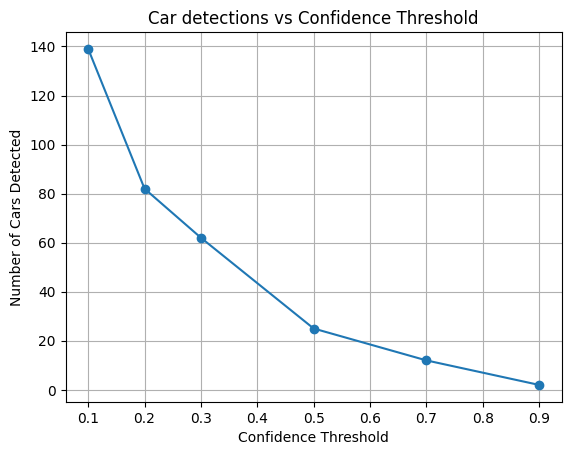

In [43]:
conf_list = [0.1,0.2,0.3,0.5,0.7,0.9]
counts = []

for conf in conf_list:
    total = 0
    for img_file in glob.glob("/content/content/Lab 4/images/*.*"):
        boxes, scores, classes = run_yolov8(img_file, score_threshold=conf, iou_threshold=0.45)
        total += (classes == class_names.index("car")).sum()
    counts.append(total)

plt.plot(conf_list, counts, marker="o")
plt.xlabel("Confidence Threshold")
plt.ylabel("Number of Cars Detected")
plt.title("Car detections vs Confidence Threshold")
plt.grid(True)
plt.show()


# Lab 4 Wrap-Up – Autonomous Driving: Car Detection

In this lab, you:

- Reviewed **CNN basics** and their role in object detection.  
- Applied a **pretrained YOLOv8 model** to detect cars (and other objects) in road scenes.  
- Learned to **draw bounding boxes** and filter by class.  
- Experimented with **confidence and IoU thresholds**, seeing their effect on detections.  
- Completed **Advanced Tasks**:  
  1. Multi-class detection comparison (bar/pie charts).  
  2. Confidence threshold sweeps and their effect on car counts.

---

### 📌 Final Deliverable
1. Make sure your notebook is clean, well-commented, and runs end-to-end.  
2. Upload your updated notebook (`autonomous_driving_application_car_detection.ipynb`) to your **GitHub repository**.  
3. Submit the **GitHub link** on **CourseWeb** as your final submission for Lab 4.

---

